In [1]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time
from scipy.fft import fftfreq, rfftfreq
from scipy.fft import rfft, irfft
# from scipy.fft import dct as rfft
# from scipy.fft import idct as irfft

import sys
sys.path.append('..')
import QLCstuff2 as QLC_nonDim
import QLCstuff as QLC_normal
import f90nml

In [2]:
%matplotlib ipympl
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

In [3]:
def get_runs(sigmaI_corner_s = 1, sigma0_s = 1, c_r_s = 1, Nbar_s = 1, Nstar_s = 1,
             h_pr_s = 1, D_s = 1, nu_kin_s = 1, L_s = 1, nx_crystal_s = 1, tau_eq_s = 1,
             runtime = 50, times = 50, FT = False):
    inputfile = "GI parameters - Reference limit cycle (for testing).nml"

    # For readability ...
    print('Using parameter file '+inputfile+' ...')

    print('\nFrom the GrowthInstability (GI) namelist:')
    GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

    # Supersaturation at the corner of a facet
    sigmaI_corner = GI['sigmaI_corner'] * sigmaI_corner_s
    sigmaI_corner_units = GI['sigmaI_corner_units']
    sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
    print('sigmaI_corner =', sigmaI_corner)

    # Difference in equilibrium supersaturation between microsurfaces I and II
    sigma0 = GI['sigma0'] * sigma0_s
    sigma0_units = GI['sigma0_units']
    sigma0 = AssignQuantity(sigma0,sigma0_units)
    print('sigma0 =',sigma0)

    # Reduction of supersaturation at the facet cental
    c_r = GI['c_r'] * c_r_s
    c_r_units = GI['c_r_units']
    c_r = AssignQuantity(c_r,c_r_units)
    print('c_r =',c_r)

    # Properties of the QLL
    Nbar = GI['Nbar'] * Nbar_s; print('Nbar', Nbar) 
    Nstar = GI['Nstar'] * Nstar_s; print('Nstar', Nstar)

    # Thickness of monolayers
    h_pr = GI['h_pr'] * h_pr_s
    h_pr_units = GI['h_pr_units']
    h_pr = AssignQuantity(h_pr,h_pr_units) 
    print('h_pr =', h_pr)

    # Diffusion coeficient
    D = GI['D'] * D_s
    D_units = GI['D_units']
    D = AssignQuantity(D,D_units)
    print('D =', D)

    # Deposition velocity
    nu_kin = GI['nu_kin'] * nu_kin_s
    nu_kin_units = GI['nu_kin_units']
    nu_kin = AssignQuantity(nu_kin,nu_kin_units)
    print('nu_kin =', nu_kin)

    # Size of the facet
    L = GI['L'] * L_s
    L_units = GI['L_units']
    L = AssignQuantity(L,L_units)
    print('L =', L)

    # Crystal size -- needs to be an even number
    nx_crystal = GI['nx_crystal'] * nx_crystal_s
    print('nx (crystal) =', nx_crystal)

    # Time constant for freezing/thawing
    tau_eq = GI['tau_eq'] * tau_eq_s
    tau_eq_units = GI['tau_eq_units']
    tau_eq = AssignQuantity(tau_eq,tau_eq_units)
    print('tau_eq =',tau_eq)

    # Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
    odemethod = GI['odemethod']
    print('odemethod =',odemethod)

    #define nondimensional scalars

    t_0 = tau_eq
    x_0 = 1 / np.sqrt(D * tau_eq)
    x_0 = x_0.magnitude

    # Conversions (in case inputs are in other units)
    sigma0.ito('dimensionless')
    h_pr.ito('micrometer')
    D.ito('micrometer^2/microsecond')
    nu_kin.ito('micrometer/second')
    L.ito('micrometer')
    sigmaI_corner.ito('dimensionless')
    c_r.ito('dimensionless')
    tau_eq.ito('microsecond')
    
    x_QLC = np.linspace(-L,L,nx_crystal)
    deltax = (x_QLC[1]-x_QLC[0])
    print('Spacing of points on the ice surface =', deltax)
    sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
    #sigmaI_QLC_nondim = sigmaI_corner*(c_r.magnitude*(x_QLC.magnitude/(L.magnitude * 1))**2+1-c_r.magnitude)
    nu_kin_mlyperus = nu_kin/h_pr
    nu_kin_mlyperus.ito('1/microsecond')
    Doverdeltax2 = D/deltax**2

    RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

    # How long
    runtime_units = RT['runtime_units']
    runtime = AssignQuantity(runtime,runtime_units)
    print('runtime =', runtime)
    runtime.ito('microsecond')

    # Number of time steps to keep for reporting later
    ntimes = times

    # Flag if we want more output
    verbose = RT['verbose']

    # Specify the time interval and initial conditions
    tkeep_1Darr = np.linspace(0,runtime,ntimes)
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC_nonDim.getNQLL(Ntot_init_1D,Nstar,Nbar) #same function in both dimesnional and non dimensional

    print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
    print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    Ntotkeep_1D_nondimensional, NQLLkeep_1D_nondimensional = QLC_nonDim.run_f1d_dimensionless(\
        NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
        Nbar, 
        Nstar, 
        sigma0.magnitude, 
        nu_kin_mlyperus.magnitude,
        deltax.magnitude,
        D.magnitude,
        tau_eq.magnitude, 
        sigmaI_QLC,\
        AssignQuantity,\
        verbose=0, odemethod='RK45')
    Nicekeep_1D_nondimensional = Ntotkeep_1D_nondimensional-NQLLkeep_1D_nondimensional

    Ntotkeep_1D_cart, NQLLkeep_1D_cart = QLC_normal.run_f1d(\
        NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
        Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,\
        AssignQuantity,\
        verbose=0, odemethod='RK45')
    Nicekeep_1D_cart = Ntotkeep_1D_cart - NQLLkeep_1D_cart

    if(FT):
        DoverL2pi2 = D/L**2*np.pi**2

        Ntotkeep_1D_FT, NQLLkeep_1D_FT = QLC_normal.run_f1d_FT(\
            NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
            Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI_QLC,\
            AssignQuantity,\
            verbose=0, odemethod='RK45')
        Nicekeep_1D_FT = Ntotkeep_1D_FT-NQLLkeep_1D_FT

    val = [np.array([Ntotkeep_1D_cart, NQLLkeep_1D_cart, Nicekeep_1D_cart]), 
            np.array([Ntotkeep_1D_nondimensional, NQLLkeep_1D_nondimensional, Nicekeep_1D_nondimensional])]
    if(FT):
        val += np.array([Ntotkeep_1D_FT, NQLLkeep_1D_FT, Nicekeep_1D_FT]), 
    
    return val

In [4]:
def plot_together(list1, list2, xlist, label1 = "", label2 = ""):
    plt.figure()
    plt.plot(xlist,list1,label=label1)
    plt.plot(xlist,list2,label=label2)
    plt.xlabel('x (micrometers)')
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(xlist,(list1 - list2),label='Error')
    plt.xlabel('x (micrometers)')
    plt.grid(True)
    plt.legend()

    return (list1 - list2)

In [5]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"
GI=f90nml.read(inputfile)['GI']
nx_crystal = GI['nx_crystal']
L = GI['L']
D = GI['D']
tau_eq = GI['tau_eq']
x_QLC = np.linspace(-L,L,nx_crystal)
deltaX = (x_QLC[1]-x_QLC[0])

In [13]:
val1 = get_runs(runtime=50)
val2 = get_runs(D_s = 2, runtime=50)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.21 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45
Spacing of points on the ice surface = 0.18808777429467227 micrometer
runtime = 50 millisecond
This is a run from time 0.0 millisecond to 50.0 millisecond
dt = 1020.4081632653061 microsecond
10 % elapsed time is 0.064 minutes
20 % elapsed time is 0.121 minutes
30 % elapsed time is 0.172 minutes
40 % elapsed time is 0.229 minutes
50 % elapsed time is 0.286 minutes
60 % elapsed time is 0.346 minutes
70 % elapsed time is 0.405 minutes
80 % elapsed time is 0.460 minutes
90 % elapsed time is 0.518 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integratio

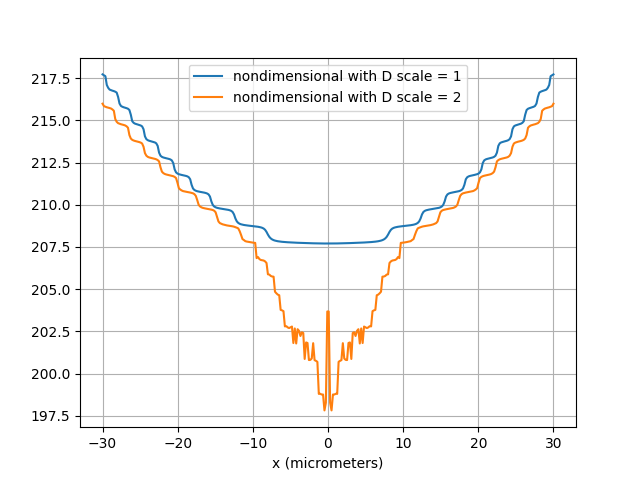

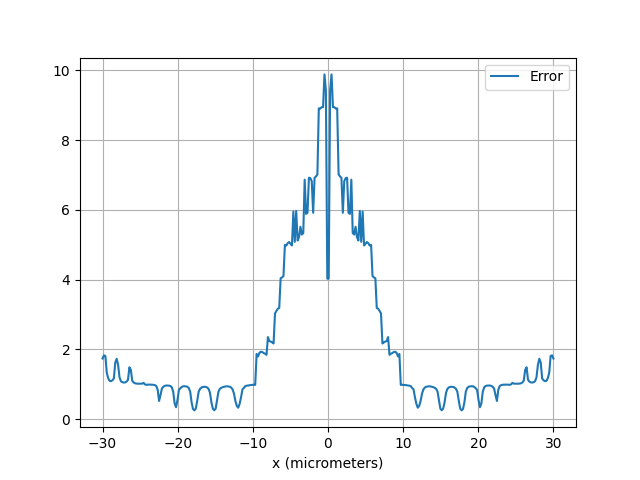

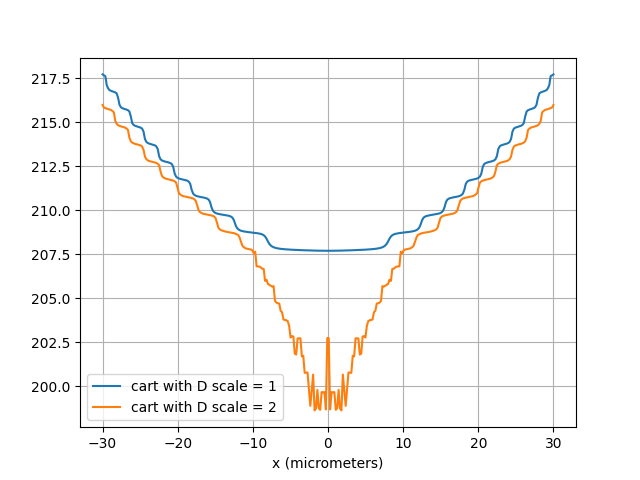

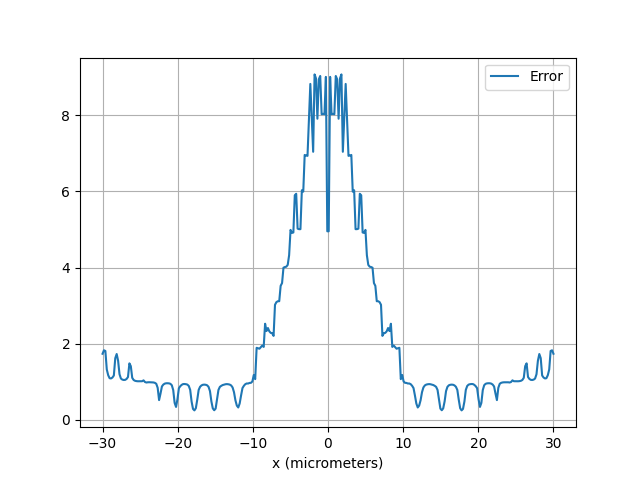

In [14]:
b = plot_together(val1[-1][0][-1], val2[-1][0][-1], x_QLC, "nondimensional with D scale = 1", "nondimensional with D scale = 2")
c = plot_together(val1[0][0][-1], val2[0][0][-1], x_QLC, "cart with D scale = 1", "cart with D scale = 2")

C:\Users\spenc\AppData\Local\Temp\ipykernel_4312\3113096610.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


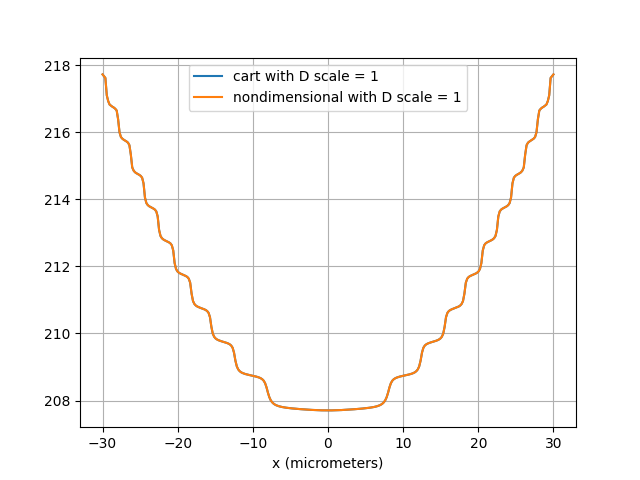

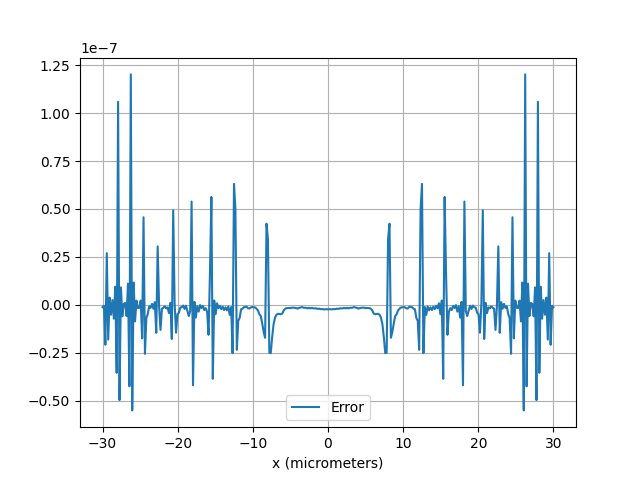

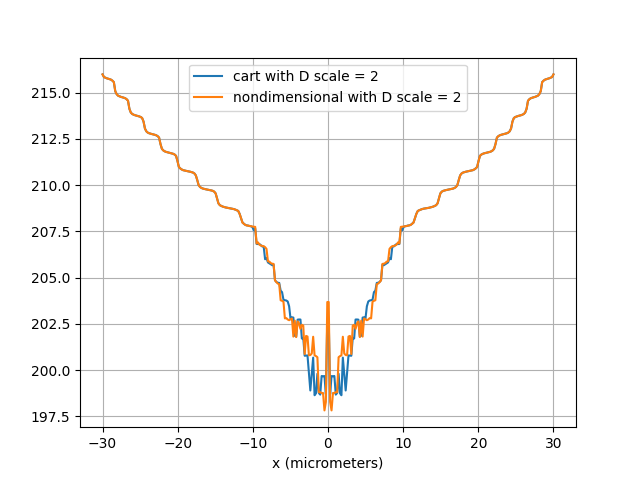

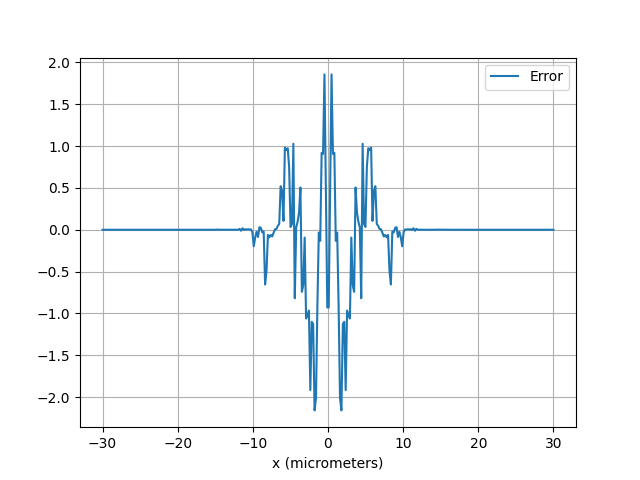

In [16]:
a = plot_together(val1[0][0][-1], val1[-1][0][-1], x_QLC, "cart with D scale = 1", "nondimensional with D scale = 1")
a = plot_together(val2[0][0][-1], val2[-1][0][-1], x_QLC, "cart with D scale = 2", "nondimensional with D scale = 2")

In [9]:
l = 320
deltaX / (np.sqrt(D * tau_eq))
4 / (deltaX * l * np.pi)**2


0.00011187657301028406